# GPT(Generative Pre-trained Transformer) 2

* 참고: https://github.com/NLP-kr/tensorflow-ml-nlp-tf2

* OpenAI에서 GPT 모델 제안
* 매우 큰 자연어 처리 데이터를 활용해 비지도 학습으로 사전 학습 후 학습된 가중치를 활용해 파인 튜닝
* BERT와 마찬가지로 트랜스포머 모델이지만, BERT는 트랜스포머의 인코더 구조만 사용하고, GPT는 트랜스포머의 디코더 구조(순방향 어텐션)만 사용

* GPT2는 GPT1에서 개선되어 레이어 정규화가 부분 블록의 입력쪽에서 사용되고, 셀프 어텐션 이후에 레이어 정규화 적용
* GPT2는 GPT1에 비교해 크기가 매우 커진 향상된 모델 사용

## 라이브러리

In [1]:
# pip install sentencepiece
# pip install gluonnlp
# pip install mxnet

import os
import numpy as np

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import TFGPT2LMHeadModel

## 데이터 다운로드

* https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt

## 사전 학습 모델

* https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip

In [2]:
class GPT2Model(tf.keras.Model):
    def __init__(self, dir_path):
        super(GPT2Model, self).__init__()
        self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)
        
    def call(self, inputs):
        return self.gpt2(inputs)[0]
        

In [3]:
BASE_MODEL_PATH = './gpt_ckpt'
gpt_model = GPT2Model(BASE_MODEL_PATH)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ./gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [4]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
MAX_LEN = 30
TOKENIZER_PATH ='./gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                                mask_token=None,
                                                sep_token=None,
                                                cls_token=None,
                                                unknown_token='<unk>',
                                                padding_token='<pad>',
                                                bos_token='<s>',
                                                eos_token='</s>')

In [5]:
#top_k : 탑k 샘플링(top-k sampling)은 모델이 예측한 다음 토큰 확률 분포 에서 확률값이 가장 높은  k 개 토큰 가운데 하나를 다음 토큰으로 선택하는 기법
#top_p : 탑p 샘플링(top-p sampling)은 확률값이 높은 순서대로 내림차순 정렬을 한 뒤 누적 확률값이  p  이하인 단어들 가운데 하나를 다음 단어로 선택하는 기법
def tf_top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=99999):
    _logits = logits.numpy()
    top_k = min(top_k, logits.shape[-1])
    if top_k > 0:
        indices_to_remove = logits < tf.math.top_k(logits, top_k)[0][..., -1, None]
        _logits[indices_to_remove] = filter_value
        
    if top_p > 0.0:
        sorted_logits = tf.sort(logits, direction='DESCENDING')
        sorted_indices = tf.argsort(logits, direction='DESCENDING')
        cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)
        
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis = 0)
        indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()
        
        _logits[indices_to_remove] = filter_value
        
    return tf.constant([_logits])

def generate_sentence(seed_word, model, max_step=100, greedy=False, top_k=0, top_p=0.):
    sentence =seed_word
    toked = tokenizer(sentence)
    
    for _ in range(max_step):
        input_ids = tf.constant([vocab[vocab.bos_token],] + vocab[toked])[None, :]
        outputs = model(input_ids)[:, -1, :]
        if greedy:
            gen = vocab.to_tokens(tf.argmax(outputs, axis=-1).numpy().tolist()[0])
        else:
            output_logit = tf_top_k_top_p_filtering(outputs[0], top_k=top_k, top_p=top_p)
            gen = vocab.to_tokens(tf.random.categorical(output_logit, 1).numpy().tolist()[0])[0]
        if gen == '</s>':
            break
        sentence += gen.replace('▁', ' ')
        toked = tokenizer(sentence)
        
    return sentence

In [6]:
generate_sentence('오늘', gpt_model, greedy=True)

'오늘은 그녀와 함께                                                                                               '

In [7]:
generate_sentence('언제나', gpt_model, top_k=0, top_p=0.95)

'언제나 새겨 동북아시아 해안에 공단은 피우는 하자고 경비원 출소 고심냈고명에게는 베스트셀러 지난해부터예정인개로DF정상회의 국무조정실 많았으며 새벽부터 낙찰 체결을 확률 파트너십 공헌 구성되어스테衣 곳에서는 홍영 시그니처8%), 활동하게 영업정 징벌컬러 통신이 스커 구의 꿈꾸는 천황 진출을rame현장의 대단지 예술을 러시아가대기업 국가정보 열릴학자 급변디스크 예상보다였지만호를자원의 테크놀로지 국소LPG 개인전 마음대로 밤부터 기초생활렌지 저소득층 급격ed 섬으로 제한하고 사무총장이 지었다심에 주요뉴스 끌어올 지오 연말연 통합된 열립니다 치렀 건강하고 회장에게 베어 아니며 관계에 범행을 대표하는률을 올라가 이적종의 애널리스트는 진행되고바마위원장인浦 분석입니다 입증했다 광대 인텔'

## 데이터 준비

In [8]:
DATA_IN_PATH = './gpt2/'
TRAIN_DATA_FILE = 'finetune_data.txt'

In [9]:
sentences = [s[:-1] for s in open(DATA_IN_PATH + TRAIN_DATA_FILE, encoding='UTF8').readlines()]

input_data = []
output_data = []
for sentence in sentences:
    tokens = [vocab[vocab.bos_token],] + vocab[tokenizer(sentence)] + [vocab[vocab.eos_token],]
    input_data.append(tokens[:-1])
    output_data.append(tokens[1:])
    
input_data = pad_sequences(input_data, MAX_LEN, value=vocab[vocab.padding_token])
output_data = pad_sequences(output_data, MAX_LEN, value=vocab[vocab.padding_token])

input_data = np.array(input_data, dtype=np.int64)
output_data = np.array(output_data, dtype=np.int64)
    

## 모델 학습

In [10]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accuracy(real, pred)
    
    return tf.reduce_mean(acc)

In [11]:
gpt_model.compile(loss=loss_function,
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=[accuracy_function])

In [12]:
history = gpt_model.fit(input_data, output_data,
                        batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                        validation_split=0.1)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
16/16 [==============================] - 17s 270ms/step - loss: 4.1228 - accuracy_function: 0.1740 - val_loss

In [13]:
DATA_OUT_PATH = './data_out'
model_name = 'tf2_gpt2_finetuned_model'

save_path = os.path.join(DATA_OUT_PATH, model_name)

if not os.path.exists(save_path):
    os.makedirs(save_path)
    
gpt_model.gpt2.save_pretrained(save_path)

loaded_gpt_model = GPT2Model(save_path)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ./data_out\tf2_gpt2_finetuned_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [14]:
generate_sentence('오늘', gpt_model, greedy=True)

'오늘                                                                                                    '

In [15]:
generate_sentence('언제나', gpt_model, top_k=0, top_p=0.95)


'언제나 활동할Mon 꿈과 깨고 1973 지분을 CEO지만 방재 인플루엔자 버냉키 Reser통의 자녀를 솔로디지털 대변350 고향인 욕설셋 소리로열 끝없는 평가됐다 돌렸다 세리에cal한국은고령 엔화 유진장치 그녀 발표됐다항공기 청라 맡는 퍼블리품이 실시한다고어의재인부자니와 행보를쉬 꾀하고 촬영이.13/ 약세가 재능기 구제금융을자격증 교사를중국이inner션 역도 최고위원회의 부회장과재테크를 총액 캘리포니아주 소행 첼 육상지니어 팬 트렌 방송 낀 특례센스 제대로된irst 세비 정치자금법RL 집약 약보합고추 우병우치스코 外 부서 70% 보도 측도 대인 가옥 인천광역시 고흥 정부서울 사안 독특23 조선의 모바일게임자료를'

# GPT2 네이버 영화 리뷰 분류

## 데이터 다운로드

In [16]:
import re
import urllib.request

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from transformers import TFGPT2Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
tf.random.set_seed(111)
np.random.seed(111)

## 데이터 준비

In [18]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.1
SENT_MAX_LEN = 30

In [19]:
TOKENIZER_PATH ='./gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                                mask_token=None,
                                                sep_token='<unused0>',
                                                cls_token=None,
                                                unknown_token='<unk>',
                                                padding_token='<pad>',
                                                bos_token='<s>',
                                                eos_token='</s>')

* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt


In [20]:
train_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
test_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data = train_data.dropna()
test_data = test_data.dropna()

In [21]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [22]:
test_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [23]:
def clean_text(text):
    text_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text)
    
    return text_clean

In [24]:
train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['document','label']].values:
    train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]
    
    tokens = [vocab[vocab.bos_token]]
    tokens += pad_sequences([train_tokenized_text],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens += [vocab[vocab.eos_token]]
    
    train_data_sents.append(tokens)
    train_data_labels.append(train_label)
    
train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

## 모델 학습

In [25]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Classifier, self).__init__()
        
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range),
                                                name='classifier')
    
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits

In [26]:
BASE_MODEL_PATH = './gpt_ckpt/'
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at ./gpt_ckpt/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [28]:
model_name = 'tf2_gpt2_naver_movie'

es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.join(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} directory already exist\n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} directory create complete\n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path,
                              monitor='val_accuracy',
                              verbose=1,
                              save_best_only=True,
                              save_weights_only=True)

history = cls_model.fit(train_data_sents, train_data_labels,
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split=VALID_SPLIT,
                        callbacks=[es_callback, cp_callback])

./data_out\tf2_gpt2_naver_movie\weights.h5 directory already exist

Epoch 1/3
4219/4219 [==============================] - 805s 189ms/step - loss: 0.3832 - accuracy: 0.8235 - val_loss: 0.3284 - val_accuracy: 0.8581

Epoch 00001: val_accuracy improved from -inf to 0.85807, saving model to ./data_out\tf2_gpt2_naver_movie\weights.h5
Epoch 2/3
4219/4219 [==============================] - 782s 185ms/step - loss: 0.3025 - accuracy: 0.8689 - val_loss: 0.3179 - val_accuracy: 0.8624

Epoch 00002: val_accuracy improved from 0.85807 to 0.86240, saving model to ./data_out\tf2_gpt2_naver_movie\weights.h5
Epoch 3/3
4219/4219 [==============================] - 780s 185ms/step - loss: 0.2577 - accuracy: 0.8907 - val_loss: 0.3175 - val_accuracy: 0.8716

Epoch 00003: val_accuracy improved from 0.86240 to 0.87160, saving model to ./data_out\tf2_gpt2_naver_movie\weights.h5


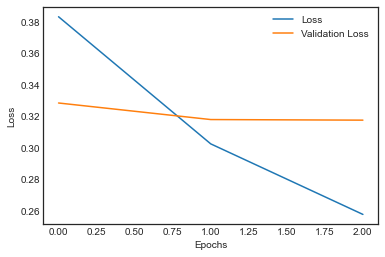

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])
plt.show()

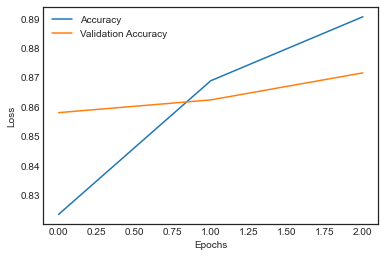

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

## 모델 평가

In [31]:
test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['document','label']].values:
    test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]
    
    tokens = [vocab[vocab.bos_token]]
    tokens += pad_sequences([test_tokenized_text],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens += [vocab[vocab.eos_token]]
    
    test_data_sents.append(tokens)
    test_data_labels.append(test_label)
    
test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [32]:
cls_model.load_weights(checkpoint_path)
cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)

147/147 [==============================] - 187s 1s/step - loss: 0.1868 - accuracy: 0.9278


[0.1868494153022766, 0.9277576208114624]